In [1]:
import numpy as np
import epde.interface.interface as epde_alg
import torch
from epde.interface.prepared_tokens import CustomTokens, CacheStoredTokens, ExternalDerivativesTokens, TrigonometricTokens
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import re

import matplotlib as mpl
mpl.rc('text', usetex=False)

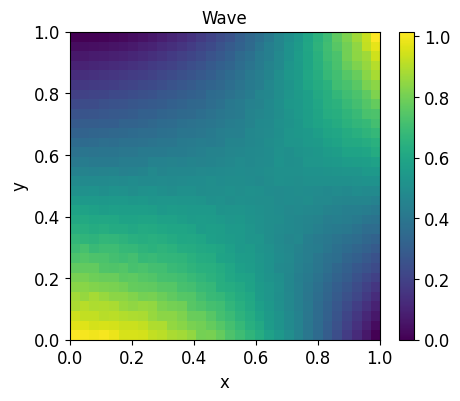

In [48]:
#Laplace         
data = np.load('data_laplace_noise0.01.npy')         
grid_x = np.linspace(0, 1, 32)
grid_y = np.linspace(0, 1, 32)
x = np.linspace(0, 1, 32)
y = np.linspace(0, 1, 32)
deriv_x = np.load('Laplace_Inverse_x_noise0.01.npy')
deriv_xx = np.load('Laplace_Inverse_xx_noise0.01.npy')
deriv_y = np.load('Laplace_Inverse_y_noise0.01.npy')
deriv_yy = np.load('Laplace_Inverse_yy_noise0.01.npy')

boundary = 5
dimensionality = data.ndim - 1   
grids = np.meshgrid(y, x, indexing = 'ij')    

plt.figure(figsize=(5, 4))
plt.imshow(data, aspect='auto', extent=[np.min(x), np.max(x),np.min(y), np.max(y)], cmap='viridis')
plt.colorbar()
plt.title('Wave')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [49]:
multiobjective_mode = True
epde_search_obj = epde_alg.EpdeSearch(multiobjective_mode=multiobjective_mode, use_solver = False, 
                                        dimensionality = dimensionality, boundary = 5,
                                        coordinate_tensors = grids)

#epde_search_obj.set_preprocessor(default_preprocessor_type='poly', # use_smoothing = True
 #                                    preprocessor_kwargs={'use_smoothing' : False})    
popsize = 7
if multiobjective_mode:
    epde_search_obj.set_moeadd_params(population_size = popsize, 
                                        training_epochs=80)
else:
    epde_search_obj.set_singleobjective_params(population_size = popsize, 
                                                training_epochs=80)

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x0000011AB699C6E0>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x0000011AB699C6E0>


In [50]:
print(grids[0].shape)
print(grids[1].shape)
print(deriv_x.shape)
print(data.shape)

(32, 32)
(32, 32)
(32, 32)
(32, 32)


In [51]:
custom_grid_tokens = CacheStoredTokens(token_type = 'grid',                                     
                                       token_labels = ['x', 't'],
                                        token_tensors={'x' : grids[0], 't' : grids[1]},
                                        params_ranges = {'power' : (1, 1)},
                                        params_equality_ranges = None)

custom_derivxx_token = CacheStoredTokens(token_type='deriv', 
                                       token_labels=['u_yy', 'u_yy'],
                                       token_tensors={'u_yy': deriv_yy, 'u_yy': deriv_yy}, 
                                       params_ranges={'power': (1, 1)},
                                       params_equality_ranges = None,
                                       unique_token_type=False,
                                       unique_specific_token = True,
                                       meaningful=True)

trig_tokens = TrigonometricTokens(dimensionality = dimensionality)


trig_token_params: VALUES = (0, 1)


In [52]:
#Laplace
factors_max_number = {'factors_num' : [1, 2], 'probas' : [0.8, 0.2]}

derivs = np.stack((deriv_yy.reshape(-1),
                   deriv_xx.reshape(-1)), axis=1)


print('data.shape =', torch.tensor(data).shape)
print('derivs.shape = ', torch.tensor(derivs).shape)
opt_val = 1e-4
bounds = (1e-10, 1e0) if multiobjective_mode else (opt_val, opt_val) 

results = []

for i in range(50):
    epde_search_obj.fit(data=data, variable_names=['u',], max_deriv_order=(1, 1), derivs = [derivs,],
                        equation_terms_max_number=5, data_fun_pow=1, 
                        additional_tokens=[custom_grid_tokens, trig_tokens],
                        equation_factors_max_number=factors_max_number,
                        eq_sparsity_interval=bounds)
    text_eq = epde_search_obj.equations(only_print=False, only_str=True, num=1)
    results.extend(text_eq)  
results = list(itertools.chain.from_iterable(results))
print(results)


data.shape = torch.Size([32, 32])
derivs.shape =  torch.Size([1024, 2])
Deriv orders after definition [[None], [0], [1]]
initial_shape (32, 32) derivs_tensor.shape (1024, 2)
self.tokens is ['u', 'du/dx0', 'du/dx1']
Here, derivs order is {'u': [None], 'du/dx0': [0], 'du/dx1': [1]}
The cardinality of defined token pool is [3 2 2]
Among them, the pool contains [3]
Creating new equation, sparsity value [2.13525096e-07]
New solution accepted, confirmed 1/7 solutions.
Creating new equation, sparsity value [0.19593761]
New solution accepted, confirmed 2/7 solutions.
Creating new equation, sparsity value [0.00018421]
New solution accepted, confirmed 3/7 solutions.
Creating new equation, sparsity value [2.48566465e-09]
New solution accepted, confirmed 4/7 solutions.
Creating new equation, sparsity value [7.0043192e-07]
New solution accepted, confirmed 5/7 solutions.
Creating new equation, sparsity value [0.01146176]
New solution accepted, confirmed 6/7 solutions.
Creating new equation, sparsity

In [14]:
#Laplace
factors_max_number = {'factors_num' : [1, 2], 'probas' : [0.8, 0.2]}

derivs = np.stack((deriv_y.reshape(-1),
                   deriv_yy.reshape(-1),
                   deriv_x.reshape(-1),
                   deriv_xx.reshape(-1)), axis=1)


print('data.shape =', torch.tensor(data).shape)
print('derivs.shape = ', torch.tensor(derivs).shape)
opt_val = 1e-4
bounds = (1e-10, 1e-2) if multiobjective_mode else (opt_val, opt_val) 

results = []

for i in range(10):
    epde_search_obj.fit(data=data, variable_names=['u',], max_deriv_order=(2, 2), derivs = [derivs,],
                        equation_terms_max_number=5, data_fun_pow=1, 
                        additional_tokens=[custom_grid_tokens],
                        equation_factors_max_number=factors_max_number,
                        eq_sparsity_interval=bounds)
    text_eq = epde_search_obj.equations(only_print=False, only_str=True, num=1)
    results.extend(text_eq)  
results = list(itertools.chain.from_iterable(results))
print(results)


data.shape = torch.Size([32, 32])
derivs.shape =  torch.Size([1024, 4])
Creating new equation, sparsity value [0.00377423]
New solution accepted, confirmed 1/7 solutions.
Creating new equation, sparsity value [1.44674569e-10]
New solution accepted, confirmed 2/7 solutions.
Creating new equation, sparsity value [1.13530064e-09]
New solution accepted, confirmed 3/7 solutions.
Creating new equation, sparsity value [3.03009467e-10]
New solution accepted, confirmed 4/7 solutions.
Creating new equation, sparsity value [1.77639389e-08]
New solution accepted, confirmed 5/7 solutions.
Creating new equation, sparsity value [4.89288607e-06]
New solution accepted, confirmed 6/7 solutions.
Creating new equation, sparsity value [1.73063034e-10]
New solution accepted, confirmed 7/7 solutions.
[0.12, 0.88] [[0.9400000000000001, 0.05999999999999994], [0.5, 0.5], [0.08, 0.92], [0.72, 0.28], [0.16, 0.84], [0.12, 0.88]]
best_obj 2
Multiobjective optimization : 0-th epoch.
During MO : processing 0-th weigh

In [53]:
results


["0.0 * du/dx1{power: 1.0} * x{power: 1.0} + 0.4834161406127093 * du/dx0{power: 1.0} + 0.0 * du/dx0{power: 1.0} * sin{power: 1.0, freq: 5.752684859843412, dim: 0.0} + 0.0 * du/dx1{power: 1.0} + -0.05299202354816916 = u{power: 1.0} * du/dx0{power: 1.0}\n{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.8, 0.2]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.041248986614106024}}",
 "0.0 * du/dx1{power: 1.0} + 3.6513939745193937 * u{power: 1.0} + 0.5124448303154027 * du/dx0{power: 1.0} + 0.0 * u{power: 1.0} * sin{power: 1.0, freq: 2.260201598934204, dim: 0.0} + -1.9891813930284485 = du/dx0{power: 1.0} * u{power: 1.0}\n{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.8, 0.2]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.03480393086690328}}",
 "0.7112975037084472 * du/dx0{power: 1.0} + 0

In [54]:
#переносим все в левую часть и сохраняем в таком виде
def transform_equation(equation):
    left_side, right_side = equation.split('=')
    left_side = left_side.strip()
    right_side = right_side.strip().split('\n')[0]  
    new_term = f"-1.0 * {right_side}"
    left_side_parts = left_side.split('+')
    left_side_parts = [part.strip() for part in left_side_parts]
    last_term = left_side_parts[-1]
    
    left_side_parts.insert(-1, new_term) 
    
    final_left_side = ' + '.join(left_side_parts)
    final_equation = f"{final_left_side} = 0.0\n{equation.split('\n', 1)[-1]}"
    
    return final_equation

transformed_results = [transform_equation(eq) for eq in results]

for transformed in transformed_results:
    print(transformed)

0.0 * du/dx1{power: 1.0} * x{power: 1.0} + 0.4834161406127093 * du/dx0{power: 1.0} + 0.0 * du/dx0{power: 1.0} * sin{power: 1.0, freq: 5.752684859843412, dim: 0.0} + 0.0 * du/dx1{power: 1.0} + -1.0 * u{power: 1.0} * du/dx0{power: 1.0} + -0.05299202354816916 = 0.0
{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.8, 0.2]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.041248986614106024}}
0.0 * du/dx1{power: 1.0} + 3.6513939745193937 * u{power: 1.0} + 0.5124448303154027 * du/dx0{power: 1.0} + 0.0 * u{power: 1.0} * sin{power: 1.0, freq: 2.260201598934204, dim: 0.0} + -1.0 * du/dx0{power: 1.0} * u{power: 1.0} + -1.9891813930284485 = 0.0
{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.8, 0.2]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.03480393086690328}}
0.7112975037084472 * du/dx0{p

In [55]:
transformed_results

["0.0 * du/dx1{power: 1.0} * x{power: 1.0} + 0.4834161406127093 * du/dx0{power: 1.0} + 0.0 * du/dx0{power: 1.0} * sin{power: 1.0, freq: 5.752684859843412, dim: 0.0} + 0.0 * du/dx1{power: 1.0} + -1.0 * u{power: 1.0} * du/dx0{power: 1.0} + -0.05299202354816916 = 0.0\n{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.8, 0.2]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.041248986614106024}}",
 "0.0 * du/dx1{power: 1.0} + 3.6513939745193937 * u{power: 1.0} + 0.5124448303154027 * du/dx0{power: 1.0} + 0.0 * u{power: 1.0} * sin{power: 1.0, freq: 2.260201598934204, dim: 0.0} + -1.0 * du/dx0{power: 1.0} * u{power: 1.0} + -1.9891813930284485 = 0.0\n{'terms_number': {'optimizable': False, 'value': 5}, 'max_factors_in_term': {'optimizable': False, 'value': {'factors_num': [1, 2], 'probas': [0.8, 0.2]}}, ('sparsity', 'u'): {'optimizable': True, 'value': 0.03480393086690328}}",
 "0.711297503708447

In [56]:
results = transformed_results
np.save('results_Laplace_Inverse_noise0.01.npy', results)


In [58]:
#расстояние Хэмминга
results_list = []

pattern_d2u_dx1_2 = r"(-?\d+\.\d+) \* du/dx1\{power: 1\.0\} \+"
pattern_d2u_dx0_2 = r"(-?\d+\.\d+) \* du/dx0\{power: 1\.0\} \+"


for eq in results:
    matches_d2u_dx1_2 = re.findall(pattern_d2u_dx1_2, eq)
    matches_d2u_dx0_2 = re.findall(pattern_d2u_dx0_2, eq)

    count_nz_coefficients = sum(1 for match in matches_d2u_dx1_2 if float(match) != 0) + sum(1 for match in matches_d2u_dx0_2 if float(match) != 0)

    results_list.append(count_nz_coefficients)

missing = [2 - x for x in results_list]

print('колво нужных членов', results_list)
print('не хватает', missing)

def count_nonzero_coefficients(equation):
    left_side = equation.split('=')[0]
    coefficients = left_side.split('+')
    nonzero_count = sum(1 for coef in coefficients if coef.strip() and not coef.strip().startswith('00') and float(coef.split('*')[0].strip()) != 00)
    
    return nonzero_count

nonzero_coefficients_counts = [count_nonzero_coefficients(eq) - 1 for eq in results]
print('общее количество ненулевых коэффов', nonzero_coefficients_counts)

extra = [a - b for a, b in zip(nonzero_coefficients_counts, results_list)]
print('лишние', extra)

ham = [a + b for a, b in zip(extra, missing)]
print('расстояние Хэмминга', ham)
print('среднее расстояние Хэмминга', np.mean(ham))
np.save('Hamming_Laplace_Inverse_noise0.01.npy', ham)

def calculate_mean_and_confidence_interval(data, confidence=0.95):
    # Проверка на пустой список
    if len(data) == 0:
        raise ValueError("Список не должен быть пустым")
    
    # Вычисление среднего
    mean = np.mean(data)
    rounded_mean = round(mean)
    
    # Вычисление стандартного отклонения и размера выборки
    std_dev = np.std(data, ddof=1)  # Используем ddof=1 для выборочной оценки
    n = len(data)
    
    # Вычисление стандартной ошибки
    standard_error = std_dev / np.sqrt(n)
    
    # Вычисление доверительного интервала
    h = standard_error * stats.t.ppf((1 + confidence) / 2, n - 1)
    confidence_interval = (rounded_mean - h, rounded_mean + h)
    
    return rounded_mean, confidence_interval

mean, ci = calculate_mean_and_confidence_interval(ham)
print(f"Округленное среднее: {mean}")
print(f"Доверительный интервал: {ci}")
# Создание нового датафрейма с единственной строкой
result_df = pd.DataFrame({
    'Метод': ['Inverse'],
    'Среднее': [mean],
    'Доверительный интервал': [ci],
})

print(result_df)
result_df.to_csv('Ham_Laplace_Inverse_noise0.01.csv', index=False, encoding='utf-8')


колво нужных членов [1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [59]:
results_list = []

pattern_d2u_dx1_2 = r"(-?\d+\.\d+) \* du/dx1\{power: 1\.0\} \+"
pattern_d2u_dx0_2 = r"(-?\d+\.\d+) \* du/dx0\{power: 1\.0\} \+"
pattern_free = r"([\+\-]?[0-9]*\.?[0-9]+(?:e[\+\-]?[0-9]+)?)\s*=\s*0\.0"

for eq in results:
    matches_d2u_dx1_2 = re.findall(pattern_d2u_dx1_2, eq)
    matches_d2u_dx0_2 = re.findall(pattern_d2u_dx0_2, eq)

    match_free = re.search(pattern_free, eq)

    results_list.extend([("d^2u/dx1^2", float(coeff)) for coeff in matches_d2u_dx1_2 if float(coeff) != 0])
    results_list.extend([("d^2u/dx0^2", float(coeff)) for coeff in matches_d2u_dx0_2 if float(coeff) != 0])
'''
    if match_free:
        free_coeff = float(match_free.group(1))
        if free_coeff != 0:
            results_list.append(("free", free_coeff))
'''
df = pd.DataFrame(results_list, columns=["Term", "Coefficient"])

df = df.reset_index(drop=True)
df.to_csv('results_Laplace_Inverse_cut_noise0.01.csv', index=False, encoding='utf-8')

print(df)



           Term  Coefficient
0    d^2u/dx0^2     0.483416
1    d^2u/dx0^2     0.512445
2    d^2u/dx0^2     0.711298
3    d^2u/dx0^2     0.512445
4    d^2u/dx0^2     0.710194
..          ...          ...
344  d^2u/dx0^2    -0.009316
345  d^2u/dx1^2     0.562157
346  d^2u/dx1^2     0.664693
347  d^2u/dx1^2     0.562157
348  d^2u/dx1^2     0.664693

[349 rows x 2 columns]


In [60]:
print(len(results))
print(round(0.5 * len(results)))

340
170


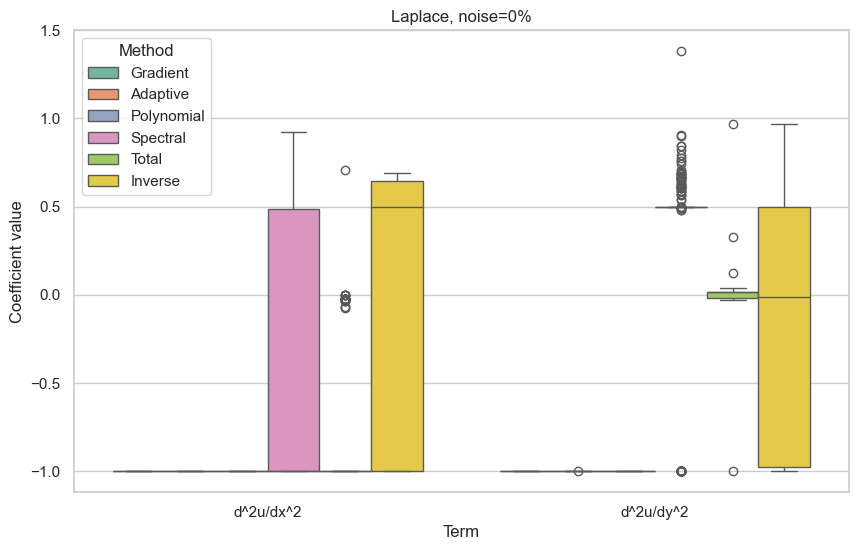

         Term      Method           Mean_CI
0   d^2u/dx^2    Gradient     -1.0000 ± nan
1   d^2u/dx^2    Adaptive     -1.0000 ± nan
2   d^2u/dx^2  Polynomial     -1.0000 ± nan
3   d^2u/dx^2    Spectral     -1.0000 ± nan
4   d^2u/dx^2     Inverse  -0.9985 ± 0.0007
5   d^2u/dx^2       Total     -1.0000 ± nan
6   d^2u/dy^2    Gradient  -0.9970 ± 0.0000
7   d^2u/dy^2    Adaptive  -0.9970 ± 0.0000
8   d^2u/dy^2  Polynomial  -0.9964 ± 0.0000
9   d^2u/dy^2    Spectral     -1.0000 ± nan
10  d^2u/dy^2     Inverse  -0.9955 ± 0.0013
11  d^2u/dy^2       Total     -1.0000 ± nan


c:\Anaconda3\envs\myenv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Anaconda3\envs\myenv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\Anaconda3\envs\myenv\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\myenv\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [2]:
#noise = 0
sns.set(style="whitegrid")

methods = ['Gradient','Adaptive','Polynomial','Spectral','Total','Inverse']
dataframes = []

for method in methods:
    df = pd.read_csv(f'results_Laplace_{method}_cut_noise0.csv')
    df['Method'] = method  # добавляем столбец с методом
    dataframes.append(df)

all_data = pd.concat(dataframes, ignore_index=True)
#переименуем слагаемые
all_data['Term'] = all_data['Term'].replace({'d^2u/dx0^2': "d^2u/dy^2", 'd^2u/dx1^2': "d^2u/dx^2" })
#print(all_data)
# Удаляем выбросы
Q1 = all_data['Coefficient'].quantile(0.25)
Q3 = all_data['Coefficient'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = all_data[(all_data['Coefficient'] >= lower_bound) & (all_data['Coefficient'] <= upper_bound)]

plt.figure(figsize=(10, 6))
sns.boxplot(x="Term", y="Coefficient", hue="Method", data=all_data, palette="Set2", dodge=True)

plt.title('Laplace, noise=0%')
plt.xlabel('Term')
plt.ylabel('Coefficient value')
plt.legend(title='Method')
# Сохраняем график в svg и pdf
plt.savefig('plot_Laplace_noise0.svg', format='svg')
plt.savefig('plot_Laplace_noise0.pdf', format='pdf')
plt.show()

# Определяем список слагаемых и методов
terms = ['d^2u/dx^2', 'd^2u/dy^2']
methods = ['Gradient', 'Adaptive', 'Polynomial', 'Spectral', 'Inverse', 'Total']

# Создаем пустой DataFrame для хранения результатов
results = []

# Функция для вычисления среднего и доверительного интервала
def compute_mean_and_ci(group):
    mean = group['Coefficient'].mean()
    ci = stats.t.interval(0.95, len(group['Coefficient'])-1, loc=mean, scale=stats.sem(group['Coefficient']))
    return mean, (ci[1] - mean)  # Возвращаем среднее и половину доверительного интервала

# Проходим по каждому слагаемому и методу
for term in terms:
    for method in methods:
        # Фильтруем данные по текущему слагаемому и методу
        subset = filtered_data[(filtered_data['Term'] == term) & (filtered_data['Method'] == method)]
        
        # Если есть данные, вычисляем среднее и доверительный интервал
        if not subset.empty:
            mean, margin_of_error = compute_mean_and_ci(subset)
            results.append({'Term': term, 'Method': method, 
                            'Mean_CI': f"{mean:.4f} ± {margin_of_error:.4f}"})

# Создаем DataFrame из результатов
results_df = pd.DataFrame(results)

# Выводим результаты
print(results_df)


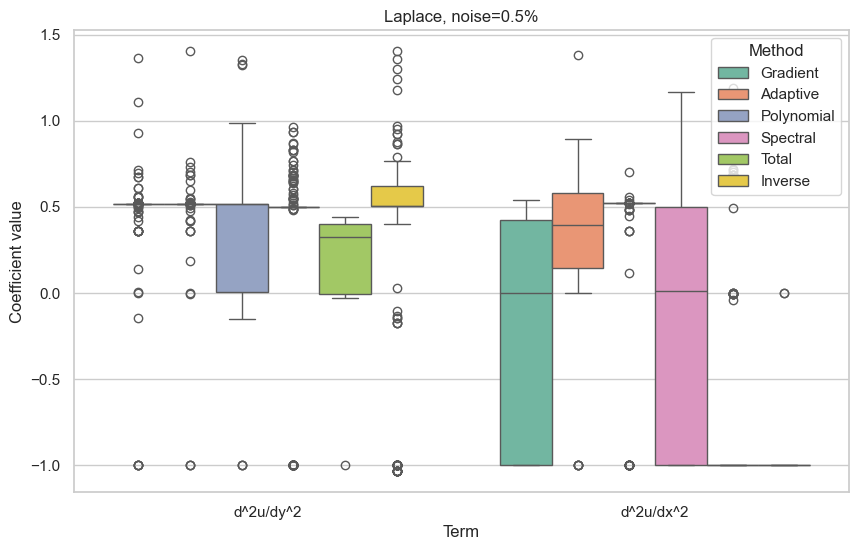

         Term      Method           Mean_CI
0   d^2u/dx^2    Gradient   0.2072 ± 0.1540
1   d^2u/dx^2    Adaptive   0.4755 ± 0.1158
2   d^2u/dx^2  Polynomial   0.5139 ± 0.0077
3   d^2u/dx^2    Spectral   0.4728 ± 0.0783
4   d^2u/dx^2     Inverse  -0.0000 ± 0.0025
5   d^2u/dx^2       Total   0.3411 ± 0.1787
6   d^2u/dy^2    Gradient   0.5129 ± 0.0095
7   d^2u/dy^2    Adaptive   0.5150 ± 0.0065
8   d^2u/dy^2  Polynomial   0.3348 ± 0.0365
9   d^2u/dy^2    Spectral   0.5393 ± 0.0137
10  d^2u/dy^2     Inverse   0.5579 ± 0.0239
11  d^2u/dy^2       Total   0.1874 ± 0.0382


In [3]:
#noise = 0.005
sns.set(style="whitegrid")

methods = ['Gradient','Adaptive','Polynomial','Spectral', 'Total','Inverse']
dataframes = []

for method in methods:
    df = pd.read_csv(f'results_Laplace_{method}_cut_noise0.005.csv')
    df['Method'] = method  # добавляем столбец с методом
    dataframes.append(df)

all_data = pd.concat(dataframes, ignore_index=True)
#переименуем слагаемые
all_data['Term'] = all_data['Term'].replace({'d^2u/dx0^2': "d^2u/dy^2", 'd^2u/dx1^2': "d^2u/dx^2" })
#print(all_data)
# Удаляем выбросы
Q1 = all_data['Coefficient'].quantile(0.25)
Q3 = all_data['Coefficient'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = all_data[(all_data['Coefficient'] >= lower_bound) & (all_data['Coefficient'] <= upper_bound)]

plt.figure(figsize=(10, 6))
sns.boxplot(x="Term", y="Coefficient", hue="Method", data=all_data, palette="Set2", dodge=True)

plt.title('Laplace, noise=0.5%')
plt.xlabel('Term')
plt.ylabel('Coefficient value')
plt.legend(title='Method')
# Сохраняем график в svg и pdf
plt.savefig('plot_Laplace_noise0.005.svg', format='svg')
plt.savefig('plot_Laplace_noise0.005.pdf', format='pdf')
plt.show()

# Определяем список слагаемых и методов
terms = ['d^2u/dx^2', 'd^2u/dy^2']
methods = ['Gradient', 'Adaptive', 'Polynomial', 'Spectral', 'Inverse', 'Total']

# Создаем пустой DataFrame для хранения результатов
results = []

# Функция для вычисления среднего и доверительного интервала
def compute_mean_and_ci(group):
    mean = group['Coefficient'].mean()
    ci = stats.t.interval(0.95, len(group['Coefficient'])-1, loc=mean, scale=stats.sem(group['Coefficient']))
    return mean, (ci[1] - mean)  # Возвращаем среднее и половину доверительного интервала

# Проходим по каждому слагаемому и методу
for term in terms:
    for method in methods:
        # Фильтруем данные по текущему слагаемому и методу
        subset = filtered_data[(filtered_data['Term'] == term) & (filtered_data['Method'] == method)]
        
        # Если есть данные, вычисляем среднее и доверительный интервал
        if not subset.empty:
            mean, margin_of_error = compute_mean_and_ci(subset)
            results.append({'Term': term, 'Method': method, 
                            'Mean_CI': f"{mean:.4f} ± {margin_of_error:.4f}"})

# Создаем DataFrame из результатов
results_df = pd.DataFrame(results)

# Выводим результаты
print(results_df)


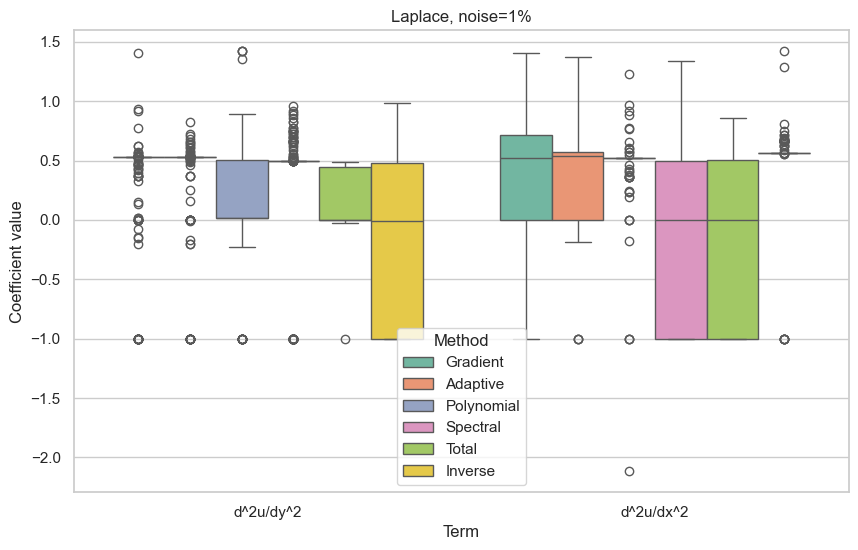

         Term      Method          Mean_CI
0   d^2u/dx^2    Gradient  0.4476 ± 0.1022
1   d^2u/dx^2    Adaptive  0.4047 ± 0.0796
2   d^2u/dx^2  Polynomial  0.5100 ± 0.0140
3   d^2u/dx^2    Spectral  0.3388 ± 0.1160
4   d^2u/dx^2     Inverse  0.5868 ± 0.0061
5   d^2u/dx^2       Total  0.3295 ± 0.0528
6   d^2u/dy^2    Gradient  0.4962 ± 0.0192
7   d^2u/dy^2    Adaptive  0.5056 ± 0.0164
8   d^2u/dy^2  Polynomial  0.2119 ± 0.0521
9   d^2u/dy^2    Spectral  0.5333 ± 0.0117
10  d^2u/dy^2     Inverse  0.3661 ± 0.0714
11  d^2u/dy^2       Total  0.2150 ± 0.0566


In [4]:
#noise = 0.01
sns.set(style="whitegrid")

methods = ['Gradient','Adaptive','Polynomial','Spectral', 'Total','Inverse']
dataframes = []

for method in methods:
    df = pd.read_csv(f'results_Laplace_{method}_cut_noise0.01.csv')
    df['Method'] = method  # добавляем столбец с методом
    dataframes.append(df)

all_data = pd.concat(dataframes, ignore_index=True)
#переименуем слагаемые
all_data['Term'] = all_data['Term'].replace({'d^2u/dx0^2': "d^2u/dy^2", 'd^2u/dx1^2': "d^2u/dx^2" })
#print(all_data)
# Удаляем выбросы
Q1 = all_data['Coefficient'].quantile(0.25)
Q3 = all_data['Coefficient'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = all_data[(all_data['Coefficient'] >= lower_bound) & (all_data['Coefficient'] <= upper_bound)]

plt.figure(figsize=(10, 6))
sns.boxplot(x="Term", y="Coefficient", hue="Method", data=all_data, palette="Set2", dodge=True)

plt.title('Laplace, noise=1%')
plt.xlabel('Term')
plt.ylabel('Coefficient value')
plt.legend(title='Method')
# Сохраняем график в svg и pdf
plt.savefig('plot_Laplace_noise0.01.svg', format='svg')
plt.savefig('plot_Laplace_noise0.01.pdf', format='pdf')
plt.show()

# Определяем список слагаемых и методов
terms = ['d^2u/dx^2', 'd^2u/dy^2']
methods = ['Gradient', 'Adaptive', 'Polynomial', 'Spectral', 'Inverse', 'Total']

# Создаем пустой DataFrame для хранения результатов
results = []

# Функция для вычисления среднего и доверительного интервала
def compute_mean_and_ci(group):
    mean = group['Coefficient'].mean()
    ci = stats.t.interval(0.95, len(group['Coefficient'])-1, loc=mean, scale=stats.sem(group['Coefficient']))
    return mean, (ci[1] - mean)  # Возвращаем среднее и половину доверительного интервала

# Проходим по каждому слагаемому и методу
for term in terms:
    for method in methods:
        # Фильтруем данные по текущему слагаемому и методу
        subset = filtered_data[(filtered_data['Term'] == term) & (filtered_data['Method'] == method)]
        
        # Если есть данные, вычисляем среднее и доверительный интервал
        if not subset.empty:
            mean, margin_of_error = compute_mean_and_ci(subset)
            results.append({'Term': term, 'Method': method, 
                            'Mean_CI': f"{mean:.4f} ± {margin_of_error:.4f}"})

# Создаем DataFrame из результатов
results_df = pd.DataFrame(results)

# Выводим результаты
print(results_df)


In [64]:
print(all_data.groupby('Term')['Coefficient'].describe())

             count      mean       std       min       25%       50%  \
Term                                                                   
d^2u/dx0^2  1101.0  0.290892  0.499959 -1.000000  0.013456  0.499624   
d^2u/dx1^2   790.0  0.284809  0.577598 -2.117326  0.363239  0.523291   

                 75%       max  
Term                            
d^2u/dx0^2  0.534040  1.419669  
d^2u/dx1^2  0.562157  1.420846  


['Gradient'] среднее [1, '±', 0.0]
['Gradient'] [0.0]
['Gradient'] [1.0]
['Gradient'] [1.0]
['Adaptive'] среднее [0, '±', 0.0159]
['Adaptive'] [0.01587123225898035]
['Adaptive'] [0.01587123225898035]
['Adaptive'] [-0.01587123225898035]
['Polynomial'] среднее [0, '±', 0.0112]
['Polynomial'] [0.011238768894712562]
['Polynomial'] [0.011238768894712562]
['Polynomial'] [-0.011238768894712562]
['Spectral'] среднее [3, '±', 0.0999]
['Spectral'] [0.09994707303415318]
['Spectral'] [3.099947073034153]
['Spectral'] [2.900052926965847]
['Inverse'] среднее [2, '±', 0.1432]
['Inverse'] [0.1432013443825385]
['Inverse'] [2.1432013443825384]
['Inverse'] [1.8567986556174614]
['Total'] среднее [2, '±', 0.1169]
['Total'] [0.11691341902473706]
['Total'] [2.116913419024737]
['Total'] [1.8830865809752628]


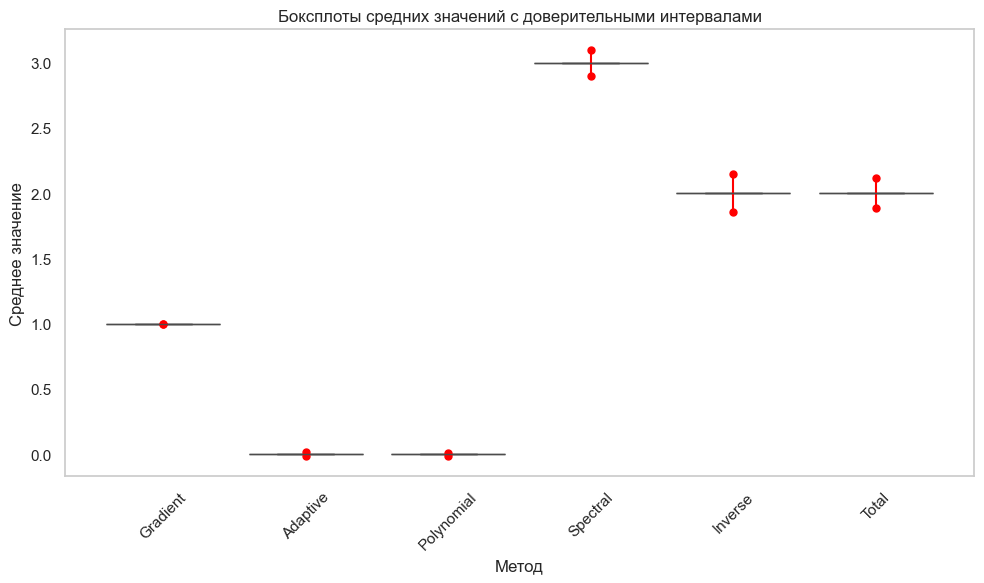

In [5]:
#noise = 0
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data1 = pd.read_csv('Ham_Laplace_Gradient_noise0.csv')
data2 = pd.read_csv('Ham_Laplace_Adaptive_noise0.csv')
data3 = pd.read_csv('Ham_Laplace_Polynomial_noise0.csv')
data4 = pd.read_csv('Ham_Laplace_Spectral_noise0.csv')
data5 = pd.read_csv('Ham_Laplace_Inverse_noise0.csv')
data6 = pd.read_csv('Ham_Laplace_Total_noise0.csv')

data1['Метод'] = 'Gradient'
data2['Метод'] = 'Adaptive'
data3['Метод'] = 'Polynomial'
data4['Метод'] = 'Spectral'
data5['Метод'] = 'Inverse'
data6['Метод'] = 'Total'


all_data = pd.concat([data1,data2, data3, data4, data5, data6], ignore_index=True)

# Извлечение нижней и верхней границ доверительного интервала
all_data['Доверительный интервал (нижний)'] = all_data['Доверительный интервал'].apply(lambda x: eval(x)[0])
all_data['Доверительный интервал (верхний)'] = all_data['Доверительный интервал'].apply(lambda x: eval(x)[1])

# Создание боксплота
plt.figure(figsize=(10, 6))
sns.boxplot(x='Метод', y='Среднее', data=all_data)

# Добавление доверительных интервалов
for i in range(len(all_data)):
    plt.plot([all_data['Метод'][i]], [all_data['Доверительный интервал (нижний)'][i]],
             color='red', marker='o', markersize=5)
    plt.plot([all_data['Метод'][i]], [all_data['Доверительный интервал (верхний)'][i]],
             color='red', marker='o', markersize=5)

    # Линия между нижним и верхним доверительным интервалом
    plt.plot([all_data['Метод'][i], all_data['Метод'][i]],
             [all_data['Доверительный интервал (нижний)'][i], all_data['Доверительный интервал (верхний)'][i]],
             color='red')

    print([all_data['Метод'][i]], 'среднее', [round(all_data['Среднее'][i], 4), "±", round((all_data['Доверительный интервал (верхний)'][i] - all_data['Доверительный интервал (нижний)'][i]) / 2, 4)])    
    print([all_data['Метод'][i]], [(all_data['Доверительный интервал (верхний)'][i] - all_data['Доверительный интервал (нижний)'][i]) / 2])
    print([all_data['Метод'][i]], [all_data['Доверительный интервал (верхний)'][i]])
    print([all_data['Метод'][i]], [all_data['Доверительный интервал (нижний)'][i]])
    
plt.title('Боксплоты средних значений с доверительными интервалами')
plt.xlabel('Метод')
plt.ylabel('Среднее значение')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


['Gradient'] среднее [2, '±', 0.0629]
['Gradient'] [0.06291480443021369]
['Gradient'] [2.0629148044302137]
['Gradient'] [1.9370851955697863]
['Adaptive'] среднее [2, '±', 0.0637]
['Adaptive'] [0.06371961806729531]
['Adaptive'] [2.0637196180672954]
['Adaptive'] [1.9362803819327048]
['Polynomial'] среднее [2, '±', 0.1062]
['Polynomial'] [0.10619332683292015]
['Polynomial'] [2.10619332683292]
['Polynomial'] [1.8938066731670797]
['Spectral'] среднее [3, '±', 0.0992]
['Spectral'] [0.09920430180845985]
['Spectral'] [3.09920430180846]
['Spectral'] [2.90079569819154]
['Inverse'] среднее [3, '±', 0.124]
['Inverse'] [0.12400870747187476]
['Inverse'] [3.1240087074718748]
['Inverse'] [2.8759912925281252]
['Total'] среднее [2, '±', 0.1084]
['Total'] [0.10843954543744727]
['Total'] [2.1084395454374474]
['Total'] [1.8915604545625528]


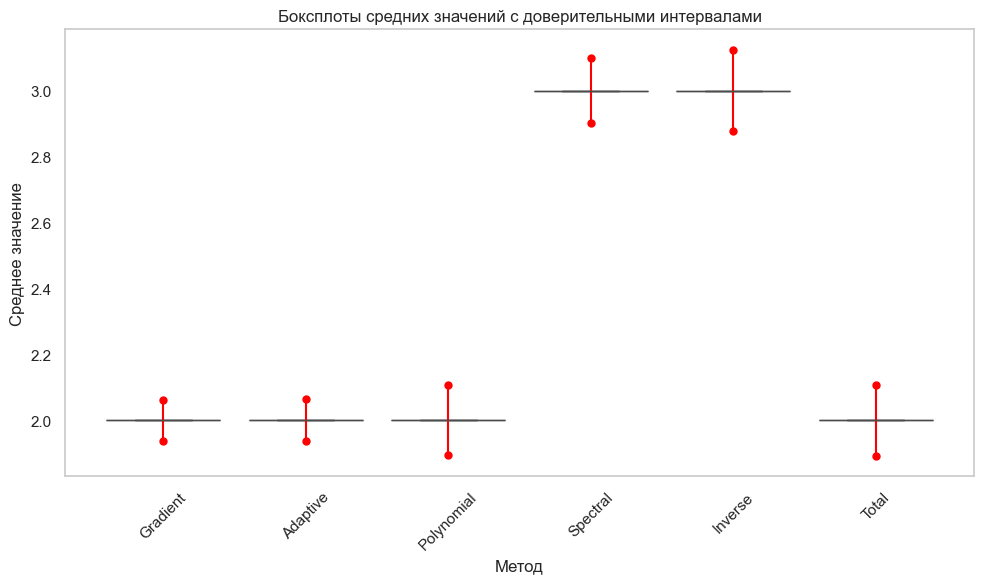

In [6]:
#noise = 0.005
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data1 = pd.read_csv('Ham_Laplace_Gradient_noise0.005.csv')
data2 = pd.read_csv('Ham_Laplace_Adaptive_noise0.005.csv')
data3 = pd.read_csv('Ham_Laplace_Polynomial_noise0.005.csv')
data4 = pd.read_csv('Ham_Laplace_Spectral_noise0.005.csv')
data5 = pd.read_csv('Ham_Laplace_Inverse_noise0.005.csv')
data6 = pd.read_csv('Ham_Laplace_Total_noise0.005.csv')

data1['Метод'] = 'Gradient'
data2['Метод'] = 'Adaptive'
data3['Метод'] = 'Polynomial'
data4['Метод'] = 'Spectral'
data5['Метод'] = 'Inverse'
data6['Метод'] = 'Total'


all_data = pd.concat([data1,data2,data3,data4,data5,data6], ignore_index=True)

# Извлечение нижней и верхней границ доверительного интервала
all_data['Доверительный интервал (нижний)'] = all_data['Доверительный интервал'].apply(lambda x: eval(x)[0])
all_data['Доверительный интервал (верхний)'] = all_data['Доверительный интервал'].apply(lambda x: eval(x)[1])

# Создание боксплота
plt.figure(figsize=(10, 6))
sns.boxplot(x='Метод', y='Среднее', data=all_data)

# Добавление доверительных интервалов
for i in range(len(all_data)):
    plt.plot([all_data['Метод'][i]], [all_data['Доверительный интервал (нижний)'][i]],
             color='red', marker='o', markersize=5)
    plt.plot([all_data['Метод'][i]], [all_data['Доверительный интервал (верхний)'][i]],
             color='red', marker='o', markersize=5)

    # Линия между нижним и верхним доверительным интервалом
    plt.plot([all_data['Метод'][i], all_data['Метод'][i]],
             [all_data['Доверительный интервал (нижний)'][i], all_data['Доверительный интервал (верхний)'][i]],
             color='red')
    print([all_data['Метод'][i]], 'среднее', [round(all_data['Среднее'][i], 4), "±", round((all_data['Доверительный интервал (верхний)'][i] - all_data['Доверительный интервал (нижний)'][i]) / 2, 4)])    
    print([all_data['Метод'][i]], [(all_data['Доверительный интервал (верхний)'][i] - all_data['Доверительный интервал (нижний)'][i]) / 2])
    print([all_data['Метод'][i]], [all_data['Доверительный интервал (верхний)'][i]])
    print([all_data['Метод'][i]], [all_data['Доверительный интервал (нижний)'][i]])
plt.title('Боксплоты средних значений с доверительными интервалами')
plt.xlabel('Метод')
plt.ylabel('Среднее значение')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


['Gradient'] среднее [2, '±', 0.0843]
['Gradient'] [0.08426993344142264]
['Gradient'] [2.0842699334414228]
['Gradient'] [1.9157300665585775]
['Adaptive'] среднее [2, '±', 0.0815]
['Adaptive'] [0.08145406325617077]
['Adaptive'] [2.081454063256171]
['Adaptive'] [1.9185459367438293]
['Polynomial'] среднее [2, '±', 0.102]
['Polynomial'] [0.1020375490807045]
['Polynomial'] [2.1020375490807046]
['Polynomial'] [1.8979624509192956]
['Spectral'] среднее [3, '±', 0.0974]
['Spectral'] [0.09735493655258676]
['Spectral'] [3.0973549365525868]
['Spectral'] [2.9026450634474132]
['Inverse'] среднее [2, '±', 0.0883]
['Inverse'] [0.0882678167830746]
['Inverse'] [2.0882678167830746]
['Inverse'] [1.9117321832169254]
['Total'] среднее [2, '±', 0.1064]
['Total'] [0.10641972926416976]
['Total'] [2.1064197292641698]
['Total'] [1.8935802707358302]


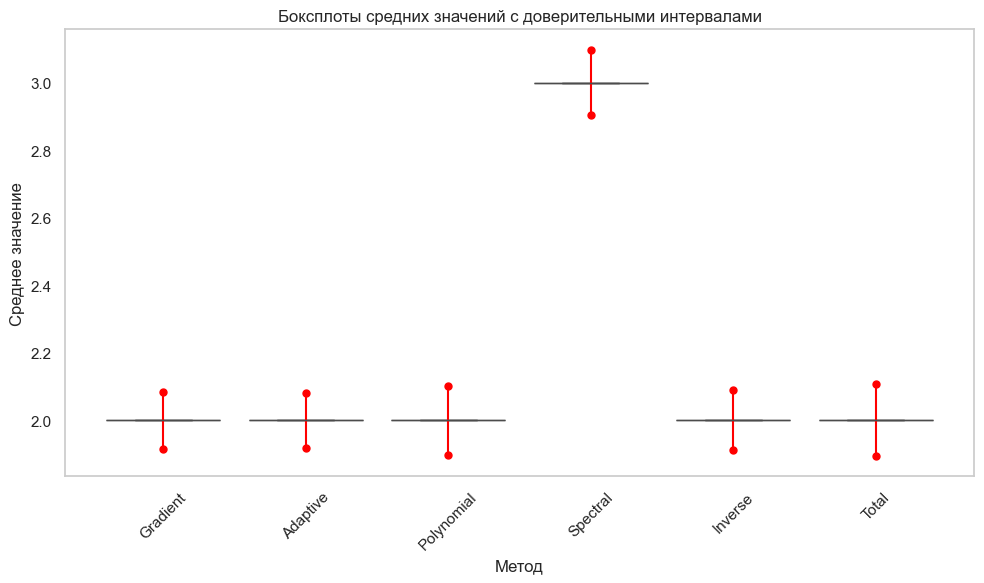

In [7]:
#noise = 0.01
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data1 = pd.read_csv('Ham_Laplace_Gradient_noise0.01.csv')
data2 = pd.read_csv('Ham_Laplace_Adaptive_noise0.01.csv')
data3 = pd.read_csv('Ham_Laplace_Polynomial_noise0.01.csv')
data4 = pd.read_csv('Ham_Laplace_Spectral_noise0.01.csv')
data5 = pd.read_csv('Ham_Laplace_Inverse_noise0.01.csv')
data6 = pd.read_csv('Ham_Laplace_Total_noise0.01.csv')

data1['Метод'] = 'Gradient'
data2['Метод'] = 'Adaptive'
data3['Метод'] = 'Polynomial'
data4['Метод'] = 'Spectral'
data5['Метод'] = 'Inverse'
data6['Метод'] = 'Total'


all_data = pd.concat([data1,data2,data3,data4,data5,data6], ignore_index=True)

# Извлечение нижней и верхней границ доверительного интервала
all_data['Доверительный интервал (нижний)'] = all_data['Доверительный интервал'].apply(lambda x: eval(x)[0])
all_data['Доверительный интервал (верхний)'] = all_data['Доверительный интервал'].apply(lambda x: eval(x)[1])

# Создание боксплота
plt.figure(figsize=(10, 6))
sns.boxplot(x='Метод', y='Среднее', data=all_data)

# Добавление доверительных интервалов
for i in range(len(all_data)):
    plt.plot([all_data['Метод'][i]], [all_data['Доверительный интервал (нижний)'][i]],
             color='red', marker='o', markersize=5)
    plt.plot([all_data['Метод'][i]], [all_data['Доверительный интервал (верхний)'][i]],
             color='red', marker='o', markersize=5)

    # Линия между нижним и верхним доверительным интервалом
    plt.plot([all_data['Метод'][i], all_data['Метод'][i]],
             [all_data['Доверительный интервал (нижний)'][i], all_data['Доверительный интервал (верхний)'][i]],
             color='red')
    print([all_data['Метод'][i]], 'среднее', [round(all_data['Среднее'][i], 4), "±", round((all_data['Доверительный интервал (верхний)'][i] - all_data['Доверительный интервал (нижний)'][i]) / 2, 4)])    
    print([all_data['Метод'][i]], [(all_data['Доверительный интервал (верхний)'][i] - all_data['Доверительный интервал (нижний)'][i]) / 2])
    print([all_data['Метод'][i]], [all_data['Доверительный интервал (верхний)'][i]])
    print([all_data['Метод'][i]], [all_data['Доверительный интервал (нижний)'][i]])
plt.title('Боксплоты средних значений с доверительными интервалами')
plt.xlabel('Метод')
plt.ylabel('Среднее значение')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


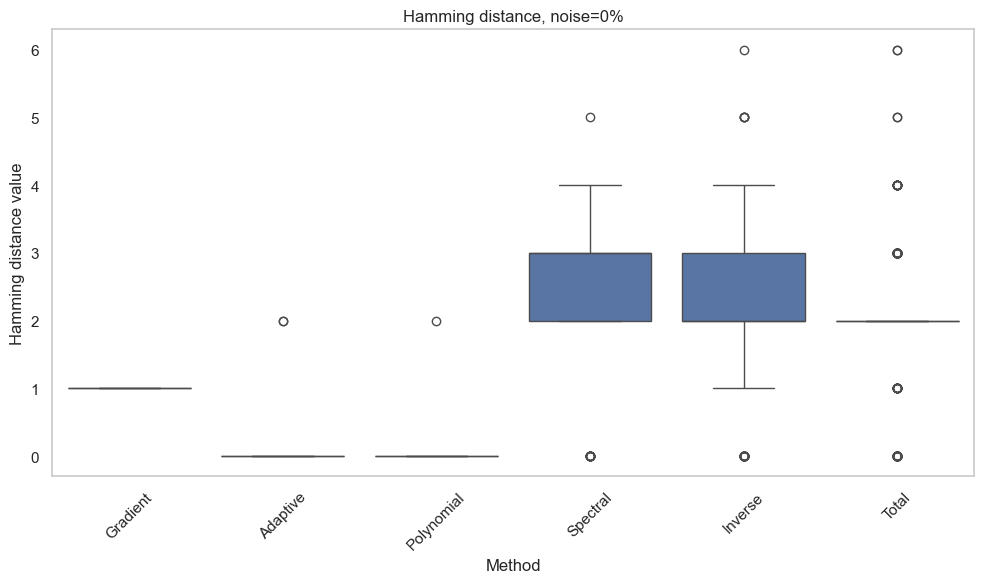

In [16]:
#noise = 0

data_gradient = np.load('Hamming_Laplace_Gradient_noise0.npy')
data_adaptive = np.load('Hamming_Laplace_Adaptive_noise0.npy')
data_polynomial = np.load('Hamming_Laplace_Polynomial_noise0.npy')
data_spectral = np.load('Hamming_Laplace_Spectral_noise0.npy')
data_inverse = np.load('Hamming_Laplace_Inverse_noise0.npy')
data_total = np.load('Hamming_Laplace_Total_noise0.npy')



df = pd.DataFrame({
    'Метод': ['Gradient'] * len(data_gradient) + ['Adaptive'] * len(data_adaptive) + ['Polynomial'] * len(data_polynomial) + ['Spectral'] * len(data_spectral)+ ['Inverse'] * len(data_inverse) + ['Total'] * len(data_total),
    'Значение': np.concatenate([data_gradient, data_adaptive, data_polynomial, data_spectral, data_inverse, data_total])
})

# Вычисление округленного среднего и доверительных интервалов
summary_df = df.groupby('Метод')['Значение'].agg(['mean', 'std']).reset_index()
summary_df['mean'] = summary_df['mean'].round()  # Округление среднего
confidence_interval = 1.96 * (summary_df['std'] / np.sqrt(df['Метод'].value_counts().values))
summary_df['Доверительный интервал (нижний)'] = summary_df['mean'] - confidence_interval
summary_df['Доверительный интервал (верхний)'] = summary_df['mean'] + confidence_interval

# Создание боксплота
plt.figure(figsize=(10, 6))
sns.boxplot(x='Метод', y='Значение', data=df)
'''
# Добавление доверительных интервалов на график
for i in range(len(summary_df)):
    plt.plot([i, i], [summary_df['Доверительный интервал (нижний)'][i], summary_df['Доверительный интервал (верхний)'][i]],
             color='red', marker='o')

    # Отметка среднего значения
    plt.plot([i - 0.1, i + 0.1], [summary_df['mean'][i], summary_df['mean'][i]], color='blue', linewidth=2)
'''
plt.title('Hamming distance, noise=0%')
plt.xlabel('Method')
plt.ylabel('Hamming distance value')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Hamming_Laplace_noise0.svg', format='svg')
plt.savefig('Hamming_Laplace_noise0.pdf', format='pdf')
plt.show()


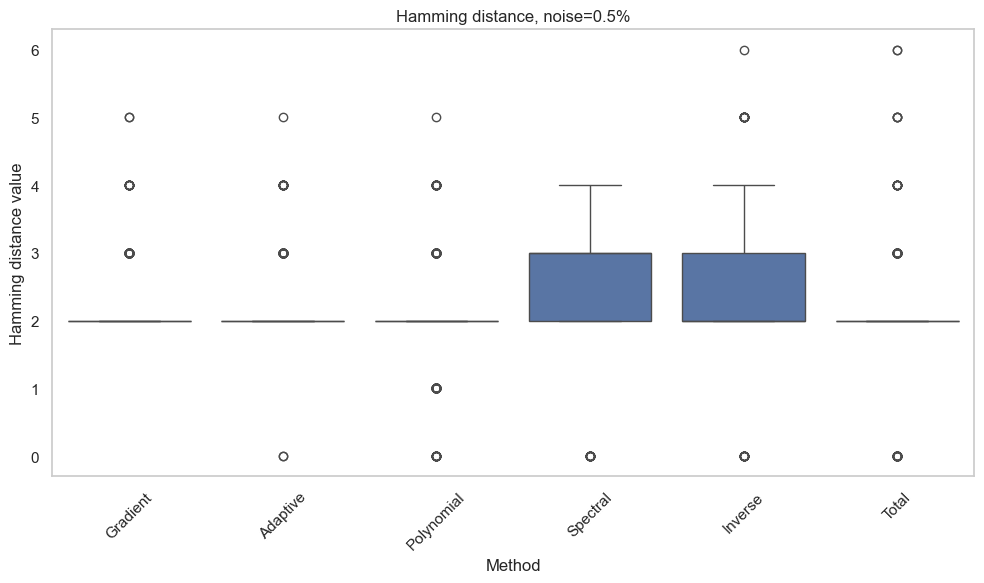

In [17]:
#noise = 0.005

data_gradient = np.load('Hamming_Laplace_Gradient_noise0.005.npy')
data_adaptive = np.load('Hamming_Laplace_Adaptive_noise0.005.npy')
data_polynomial = np.load('Hamming_Laplace_Polynomial_noise0.005.npy')
data_spectral = np.load('Hamming_Laplace_Spectral_noise0.005.npy')
data_inverse = np.load('Hamming_Laplace_Inverse_noise0.005.npy')
data_total = np.load('Hamming_Laplace_Total_noise0.005.npy')


df = pd.DataFrame({
    'Метод': ['Gradient'] * len(data_gradient) + ['Adaptive'] * len(data_adaptive) + ['Polynomial'] * len(data_polynomial) + ['Spectral'] * len(data_spectral) + ['Inverse'] * len(data_inverse) + ['Total'] * len(data_total),
    'Значение': np.concatenate([data_gradient, data_adaptive, data_polynomial, data_spectral, data_inverse, data_total])
})

# Вычисление округленного среднего и доверительных интервалов
summary_df = df.groupby('Метод')['Значение'].agg(['mean', 'std']).reset_index()
summary_df['mean'] = summary_df['mean'].round()  # Округление среднего
confidence_interval = 1.96 * (summary_df['std'] / np.sqrt(df['Метод'].value_counts().values))
summary_df['Доверительный интервал (нижний)'] = summary_df['mean'] - confidence_interval
summary_df['Доверительный интервал (верхний)'] = summary_df['mean'] + confidence_interval

# Создание боксплота
plt.figure(figsize=(10, 6))
sns.boxplot(x='Метод', y='Значение', data=df)
'''
# Добавление доверительных интервалов на график
for i in range(len(summary_df)):
    plt.plot([i, i], [summary_df['Доверительный интервал (нижний)'][i], summary_df['Доверительный интервал (верхний)'][i]],
             color='red', marker='o')

    # Отметка среднего значения
    plt.plot([i - 0.1, i + 0.1], [summary_df['mean'][i], summary_df['mean'][i]], color='blue', linewidth=2)
'''
plt.title('Hamming distance, noise=0.5%')
plt.xlabel('Method')
plt.ylabel('Hamming distance value')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Hamming_Laplace_noise0.005.svg', format='svg')
plt.savefig('Hamming_Laplace_noise0.005.pdf', format='pdf')
plt.show()


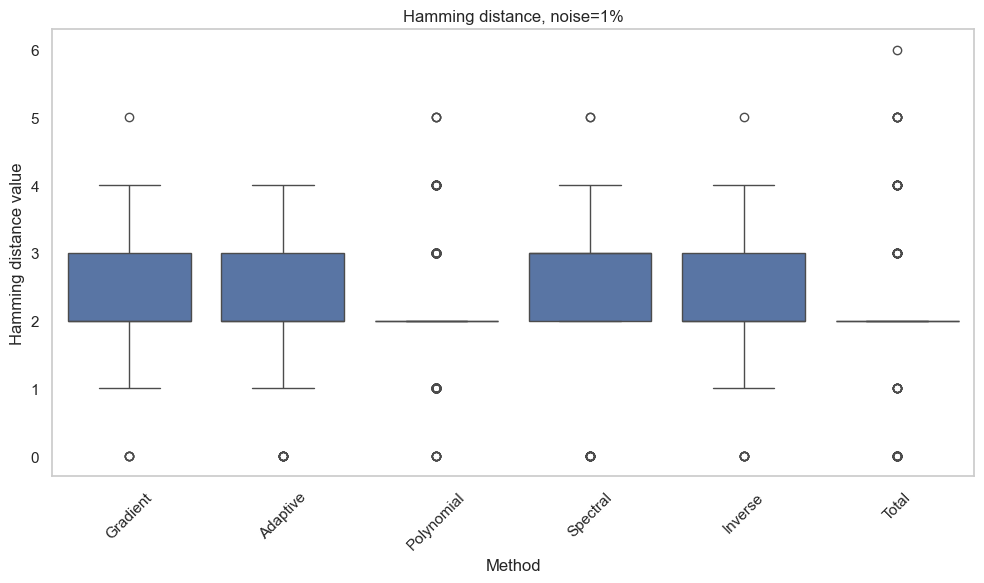

In [18]:
#noise = 0.01

data_gradient = np.load('Hamming_Laplace_Gradient_noise0.01.npy')
data_adaptive = np.load('Hamming_Laplace_Adaptive_noise0.01.npy')
data_polynomial = np.load('Hamming_Laplace_Polynomial_noise0.01.npy')
data_spectral = np.load('Hamming_Laplace_Spectral_noise0.01.npy')
data_inverse = np.load('Hamming_Laplace_Inverse_noise0.01.npy')
data_total = np.load('Hamming_Laplace_Total_noise0.01.npy')


df = pd.DataFrame({
    'Метод': ['Gradient'] * len(data_gradient) + ['Adaptive'] * len(data_adaptive) + ['Polynomial'] * len(data_polynomial) + ['Spectral'] * len(data_spectral) + ['Inverse'] * len(data_inverse) + ['Total'] * len(data_total),
    'Значение': np.concatenate([data_gradient, data_adaptive, data_polynomial, data_spectral, data_inverse, data_total])
})

# Вычисление округленного среднего и доверительных интервалов
summary_df = df.groupby('Метод')['Значение'].agg(['mean', 'std']).reset_index()
summary_df['mean'] = summary_df['mean'].round()  # Округление среднего
confidence_interval = 1.96 * (summary_df['std'] / np.sqrt(df['Метод'].value_counts().values))
summary_df['Доверительный интервал (нижний)'] = summary_df['mean'] - confidence_interval
summary_df['Доверительный интервал (верхний)'] = summary_df['mean'] + confidence_interval

# Создание боксплота
plt.figure(figsize=(10, 6))
sns.boxplot(x='Метод', y='Значение', data=df)
'''
# Добавление доверительных интервалов на график
for i in range(len(summary_df)):
    plt.plot([i, i], [summary_df['Доверительный интервал (нижний)'][i], summary_df['Доверительный интервал (верхний)'][i]],
             color='red', marker='o')

    # Отметка среднего значения
    plt.plot([i - 0.1, i + 0.1], [summary_df['mean'][i], summary_df['mean'][i]], color='blue', linewidth=2)
'''
plt.title('Hamming distance, noise=1%')
plt.xlabel('Method')
plt.ylabel('Hamming distance value')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Hamming_Laplace_noise0.01.svg', format='svg')
plt.savefig('Hamming_Laplace_noise0.01.pdf', format='pdf')
plt.show()


    day  total_bill smoker
0   Sat   11.571459    Yes
1   Sun   41.820521     No
2  Thur   25.717799     No
3   Sat   35.428535     No
4   Sat   55.378324    Yes


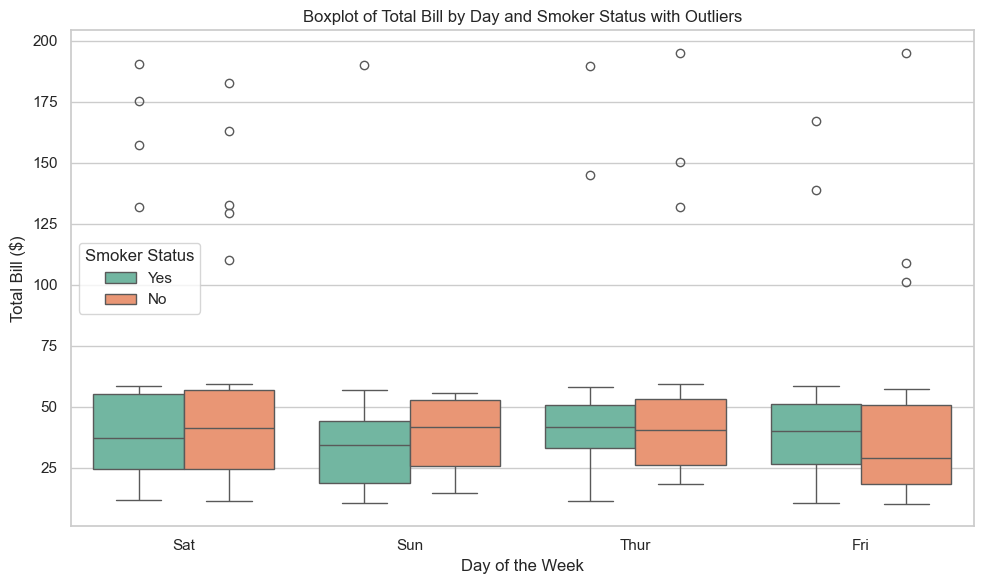

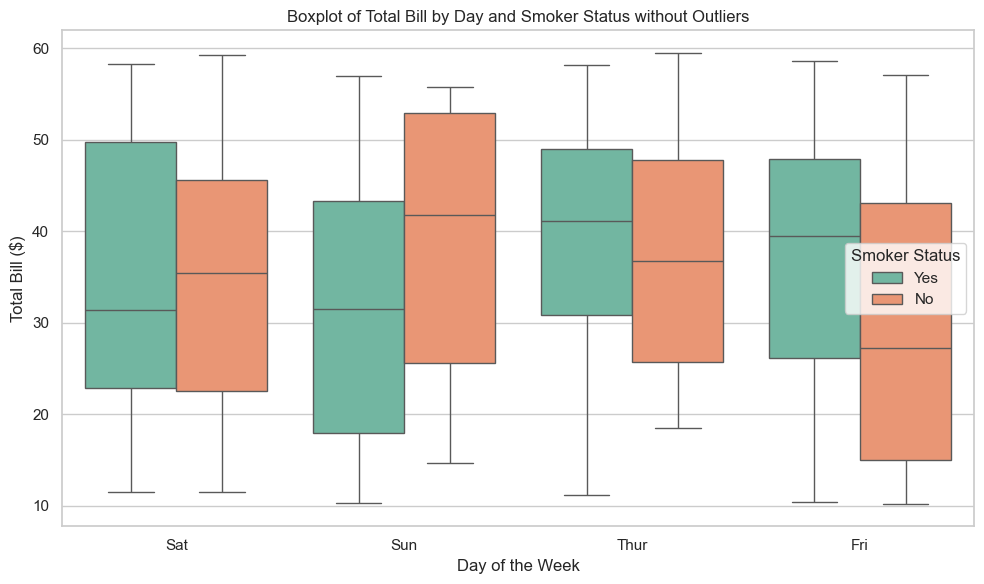

In [436]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Установка стиля графиков
sns.set(style="whitegrid")

# Установка случайного сид для воспроизводимости
np.random.seed(42)

# Создание рандомного датафрейма
days = ['Thur', 'Fri', 'Sat', 'Sun']
smoker_status = ['Yes', 'No']

# Генерация данных
data = {
    'day': np.random.choice(days, size=200),  # Случайные дни
    'total_bill': np.random.uniform(10, 60, size=200),  # Случайные суммы счетов от 10 до 60
    'smoker': np.random.choice(smoker_status, size=200)  # Случайный статус курильщика
}

# Создание DataFrame
tips = pd.DataFrame(data)

# Добавление выбросов
n_outliers = 20  # Количество выбросов
outliers = np.random.uniform(100, 200, size=n_outliers)  # Выбросы от 100 до 200

# Создание датафрейма с выбросами
outlier_data = pd.DataFrame({
    'day': np.random.choice(days, size=n_outliers),
    'total_bill': outliers,
    'smoker': np.random.choice(smoker_status, size=n_outliers)
})

# Объединение основного датафрейма с выбросами
tips = pd.concat([tips, outlier_data], ignore_index=True)

# Вывод первых нескольких строк датафрейма
print(tips.head())

# Построение боксплота с выбросами
plt.figure(figsize=(10, 6))
sns.boxplot(x="day", y="total_bill", hue="smoker", data=tips, palette="Set2", dodge=True)

# Настройка графика
plt.title('Boxplot of Total Bill by Day and Smoker Status with Outliers')
plt.xlabel('Day of the Week')
plt.ylabel('Total Bill ($)')
plt.legend(title='Smoker Status')
plt.tight_layout()

# Показываем график
plt.show()

# Удаление выбросов с использованием метода IQR
Q1 = tips['total_bill'].quantile(0.25)
Q3 = tips['total_bill'].quantile(0.75)
IQR = Q3 - Q1

# Определяем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем выбросы
filtered_tips = tips[(tips['total_bill'] >= lower_bound) & (tips['total_bill'] <= upper_bound)]

# Построение боксплота без выбросов
plt.figure(figsize=(10, 6))
sns.boxplot(x="day", y="total_bill", hue="smoker", data=filtered_tips, palette="Set2", dodge=True)

# Настройка графика
plt.title('Boxplot of Total Bill by Day and Smoker Status without Outliers')
plt.xlabel('Day of the Week')
plt.ylabel('Total Bill ($)')
plt.legend(title='Smoker Status')
plt.tight_layout()

# Показываем график
plt.show()


In [470]:
print(tips.groupby('day')['total_bill'].describe())

      count       mean        std        min        25%        50%        75%  \
day                                                                             
Fri    67.0  45.887394  34.498418  12.053376  25.419429  37.914673  52.378540   
Sat    77.0  39.348513  30.334871  10.259243  22.810347  31.923706  45.445550   
Thur   76.0  50.983419  43.802196  11.380839  23.718040  37.384005  55.945725   

             max  
day               
Fri   189.189691  
Sat   186.313852  
Thur  190.769371  
